In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [36]:
!pip install Pillow

     |████████████████████████████████| 2.2 MB 4.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [147]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=8543 sha256=99b4666bcd26b2f1321f21cd9d750c2b3c1da2b4bc5ee6696b3e9b920bd72c16
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics
You should consider upgrading via the 'pip install --upgrade pip' command.


In [189]:
# import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import argparse
import xml.etree.ElementTree as ET
import os
from PIL import Image, ImageEnhance
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, InputLayer, BatchNormalization, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D, GlobalMaxPool2D, LeakyReLU
from tensorflow.keras.regularizers import l2
from collections import defaultdict
import io
import configparser
import math
import ml_metrics 

In [2]:
print(tf.__version__)
tf.test.is_gpu_available()

2.2.0-dev20200403
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Parsing out annotations from XML into .txt

In [4]:
parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

_StoreAction(option_strings=[], dest='dir', nargs=None, const=None, default='..', type=None, choices=None, help='Annotations.', metavar=None)

In [3]:
sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('./VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))

In [4]:
for year, image_set in sets:
    print(year, image_set)
    with open(os.path.join('./VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
        image_ids = f.read().strip().split()
    with open(os.path.join("./VOCdevkit", '%s_%s.txt' % (year, image_set)), 'w') as f:
        for image_id in image_ids:
            f.write('%s/VOC%s/JPEGImages/%s.jpg' % ("VOCdevkit", year, image_id))
            convert_annotation(year, image_id, f)
            f.write('\n')

2007 train
2007 val
2007 test


array([[[4, 2, 4],
        [0, 0, 0],
        [0, 0, 2],
        [4, 0, 1],
        [1, 0, 2],
        [3, 3, 2],
        [4, 3, 2],
        [1, 2, 4],
        [4, 4, 0],
        [3, 2, 4]],

       [[0, 1, 2],
        [4, 1, 2],
        [0, 1, 3],
        [2, 1, 1],
        [2, 1, 3],
        [0, 0, 4],
        [1, 1, 0],
        [4, 2, 0],
        [0, 4, 1],
        [3, 0, 0]],

       [[0, 4, 4],
        [1, 4, 1],
        [0, 2, 0],
        [1, 0, 0],
        [3, 3, 3],
        [1, 2, 0],
        [2, 0, 2],
        [3, 3, 3],
        [4, 2, 4],
        [3, 4, 4]],

       [[3, 3, 3],
        [3, 1, 2],
        [3, 1, 3],
        [4, 0, 3],
        [4, 3, 1],
        [4, 4, 0],
        [0, 3, 1],
        [2, 0, 2],
        [1, 4, 1],
        [4, 2, 2]],

       [[2, 2, 4],
        [3, 1, 1],
        [2, 3, 3],
        [0, 3, 2],
        [2, 3, 2],
        [1, 3, 1],
        [4, 1, 1],
        [4, 0, 2],
        [4, 1, 3],
        [0, 3, 2]],

       [[0, 1, 4],
        [4, 4, 3],
  

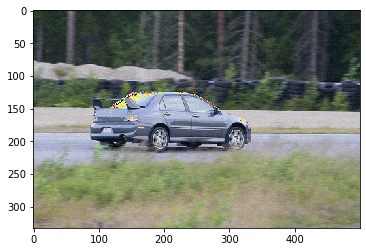

In [188]:
im = Image.open(X_train[3]).convert('RGB')
image_w, image_h = im.size[0:2]
im = np.array(im)
plt.imshow(add_noise(im, image_w, image_h))

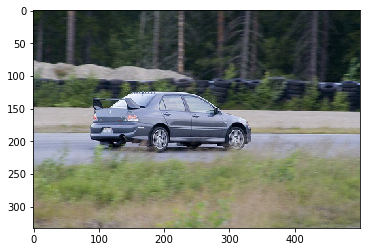

In [213]:
im = Image.open(X_train[3])
im = ImageEnhance.Sharpness(im)
im = im.enhance(0.9)
im = np.array(im)
plt.imshow(im)

In [195]:
im.shape

(333, 500, 3)

In [115]:
im = Image.open(X_train[3]).convert('RGB')
image_w, image_h = im.size[0:2]
im = np.array(im)
plt.imshow(add_noise(im, image_w, image_h))

0.17657584877398225

In [206]:
np.random.uniform(0.2, 0.8)

0.38274222504993405

In [219]:
def add_noise(img, width, height, cc=3):
    noise = np.random.randint(20, size=(height, width, 3), dtype='uint8')
    img += noise
    return img
                
def enhance(img):
    if np.random.random() > 0.5:
        im = ImageEnhance.Contrast(img)
        im = im.enhance(np.random.uniform(0.2, 0.8))
        return im
    
    elif np.random.random() > 0.5:
        im = ImageEnhance.Color(img)
        im = im.enhance(np.random.uniform(0.2, 0.8))
        return im
    
    elif np.random.random() > 0.5:
        im = ImageEnhance.Sharpness(img)
        im = im.enhance(np.random.uniform(0.2, 0.8))
        return im
    
    else:
        return img
    
def read_image(image_path, label):
    # Pillow reads in images as "RGBA" but we really want them in "RGB"
    image = Image.open(image_path)
    image = image.convert('RGB')
    
    # Augmentation 1. Need to do this before the below transforms..
    enhance(img=image)
    
    # cv2 provides (height, width, channels)
    # PIL provides (width, height, channels), so we have flipped the below tuple
    image_w, image_h = image.size[0:2]
    
    image = image.resize(size=(448, 448))
    image = np.array(image)

    # Augmentation2 adding noise
    if np.random.random() > 0.5:
        image = add_noise(img=image, width=448, height=448)
        
    image = image / 255.0

    label_matrix = np.zeros([7, 7, 30])
    for l in label:
        l = l.split(',')
        l = np.array(l, dtype=np.int)
#         print(l)
#         print(label)
#         print(image_path)
#         print(f'width: {image_w}')
#         print(f'height: {image_h}')
        xmin = l[0]
        ymin = l[1]
        xmax = l[2]
        ymax = l[3]
        cls = l[4]

        # Finding the center of the bbox along the width of the image
        x = (xmin + xmax) / 2 / image_w
#         print(f'first x: {x}')
        # Finding the center of the bbox along the height of the image
        y = (ymin + ymax) / 2 / image_h
#         print(f'first y: {y}')
        # Width and height of the bbox
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
#         print(f'w: {w}')
#         print(f'h: {h}')
        # As our image is now a 7x7 grid, we know the center of the bbox is at [7x, 7y]
        # if we imaging each gridcell to be the unit circle
        # However, we need to round to place it in our matrix... hence the int()
        loc = [7 * x, 7 * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
#         print(f'loc_i: {loc_i}')
#         print(f'loc_j: {loc_j}')
        # This last transformation tells us that the center of the bbox is y% of the way past the loc_i grid border
        y = loc[1] - loc_i
        x = loc[0] - loc_j
        
#         print(f'2nd x: {x}')
#         print(f'2nd y: {y}')
#         if loc_j == 7:
#             loc_j -= 1
#         if loc_i == 7:
#             loc_i -= 1
        # Unsure about the if statement here... isn't it always true?
        # Perhaps this is a batching thing where we don't want to label it again??
#         print(cls)
#         print(image_path)
        if label_matrix[loc_i, loc_j, 24] == 0:
            # This must be the p(c_i)...
            label_matrix[loc_i, loc_j, cls] = 1

            # This is the bbox prediction
            label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]

            # Don't know what this is???
            label_matrix[loc_i, loc_j, 24] = 1  # response
            
    return image, label_matrix

### Preparing dataset

In [220]:
class ImageGrabber(tf.keras.utils.Sequence):
    
    def __init__(self, images, labels, batch_size) :
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        
    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        train_image = []
        train_label = []

        for i in range(0, len(batch_x)):
            img_path = batch_x[i]
            label = batch_y[i]
            image, label_matrix = read_image(img_path, label)
            train_image.append(image)
            train_label.append(label_matrix)
        return np.array(train_image), np.array(train_label)

In [221]:
train_datasets = []
val_datasets = []

with open(os.path.join("VOCdevkit", '2007_train.txt'), 'r') as f:
    train_datasets = train_datasets + f.readlines()
with open(os.path.join("VOCdevkit", '2007_val.txt'), 'r') as f:
    val_datasets = val_datasets + f.readlines()

X_train = []
Y_train = []

X_val = []
Y_val = []

for item in train_datasets:
    item = item.replace("\n", "").split(" ")
    X_train.append(item[0])
    arr = []
    for i in range(1, len(item)):
        arr.append(item[i])
    Y_train.append(arr)

for item in val_datasets:
    item = item.replace("\n", "").split(" ")
    X_val.append(item[0])
    arr = []
    for i in range(1, len(item)):
        arr.append(item[i])
    Y_val.append(arr)

In [222]:
batch_size = 4
mb_train = ImageGrabber(X_train, Y_train, batch_size)

mb_test = ImageGrabber(X_val, Y_val, batch_size)

x_train, y_train = mb_train.__getitem__(0)
x_val, y_val = mb_test.__getitem__(0)
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(4, 448, 448, 3)
(4, 7, 7, 30)
(4, 448, 448, 3)
(4, 7, 7, 30)


#### Preparing ground truth files

In [183]:
# os.mkdir('./results')
# os.mkdir('./results/groundtruths')

In [233]:
for i in range(len(X_train)):
    fname = X_train[i].split('.jpg')[0].split('/')[-1] + '.txt'
    for label in Y_train[i]:
        l = label.split(',')
        box = l[:4]
        class_ = l[4]
        
        class_name = [k for k, v in classes_num.items() if v == int(class_)]
        
        to_write = class_name + box
        to_write = ' '.join(to_write)

        to_write = to_write + '\n'

        with open(os.path.join('./results/groundtruths', fname), 'a') as f:
            f.write(to_write)

# Pretrained weights

def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areaimport keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return losss
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh

def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss



In [223]:
# import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [224]:
# parser = argparse.ArgumentParser(description='Darknet Yolov1-tiny To Keras Converter.')
# parser.add_argument('config_path', help='Path to Darknet cfg file.')
# parser.add_argument('weights_path', help='Path to Darknet weights file.')
# parser.add_argument('output_path', help='Path to output Keras models file.')


def unique_config_sections(config_file):
    """Convert all config sections to have unique names.
    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream


def convert():
    print('Loading weights.')
    weights_file = open(weights_path, 'rb')
    weights_header = np.ndarray(
        shape=(4, ), dtype='int32', buffer=weights_file.read(16))
    print('Weights Header: ', weights_header)

    print('Parsing Darknet config.')
    unique_config_file = unique_config_sections(config_path)
    cfg_parser = configparser.ConfigParser()
    cfg_parser.read_file(unique_config_file)

    print('Creating Keras models.')

    try:
        image_height = int(cfg_parser['crop_0']['crop_height'])
        image_width = int(cfg_parser['crop_0']['crop_width'])
    except KeyError:
        image_height = int(cfg_parser['net_0']['height'])
        image_width = int(cfg_parser['net_0']['width'])

    prev_layer = Input(shape=(image_height, image_width, 3))
    all_layers = [prev_layer]

    weight_decay = float(cfg_parser['net_0']['decay']
                         ) if 'net_0' in cfg_parser.sections() else 5e-4
    count = 0
    
    fc_flag = False
    for section in cfg_parser.sections():
        print('Parsing section {}'.format(section))
        if section.startswith('convolutional'):
            filters = int(cfg_parser[section]['filters'])
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            pad = int(cfg_parser[section]['pad'])
            activation = cfg_parser[section]['activation']
            batch_normalize = 'batch_normalize' in cfg_parser[section]

            # padding='same' is equivalent to Darknet pad=1
            padding = 'same' if pad == 1 else 'valid'

            # Setting weights.
            # Darknet serializes convolutional weights as:
            # [bias/beta, [gamma, mean, variance], conv_weights]
            prev_layer_shape = K.int_shape(prev_layer)
            # TODO: This assumes channel last dim_ordering.
            weights_shape = (size, size, prev_layer_shape[-1], filters)
            darknet_w_shape = (filters, weights_shape[2], size, size)
            weights_size = np.product(weights_shape)

            print('conv2d', 'bn'
                  if batch_normalize else '  ', activation, weights_shape)

            conv_bias = np.ndarray(
                shape=(filters, ),
                dtype='float32',
                buffer=weights_file.read(filters * 4))
            count += filters

            bn_weight_list = []
            if batch_normalize:
                bn_weights = np.ndarray(
                    shape=(3, filters),
                    dtype='float32',
                    buffer=weights_file.read(filters * 12))
                count += 3 * filters
                
                # TODO: Keras BatchNormalization mistakenly refers to var
                # as std.
                bn_weight_list = [
                    bn_weights[0],  # scale gamma
                    conv_bias,  # shift beta
                    bn_weights[1],  # running mean
                    bn_weights[2]  # running var
                ]

            conv_weights = np.ndarray(
                shape=darknet_w_shape,
                dtype='float32',
                buffer=weights_file.read(weights_size * 4))
            count += weights_size

            # DarkNet conv_weights are serialized Caffe-style:
            # (out_dim, in_dim, height, width)
            # We would like to set these to Tensorflow order:
            # (height, width, in_dim, out_dim)
            # TODO: Add check for Theano dim ordering.
            conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
            conv_weights = [conv_weights] if batch_normalize \
                else [conv_weights, conv_bias]
            
            # Handle activation.
            act_fn = None
            if activation == 'leaky':
                pass  # Add advanced activation later.
            elif activation == 'relu':
                pass
            elif activation != 'linear':
                raise ValueError(
                    'Unknown activation function `{}` in section {}'.format(
                        activation, section))

            # Create Conv2D layer
            conv_layer = Conv2D(
                filters, (size, size),
                strides=(stride, stride),
                kernel_regularizer=l2(weight_decay),
                use_bias=not batch_normalize,
                weights=conv_weights,
                activation=act_fn,
                padding=padding,
                name=format(section))(prev_layer)

            if batch_normalize:
                conv_layer = BatchNormalization(
                    weights=bn_weight_list,
                    name='bn' + format(section))(conv_layer)

            prev_layer = conv_layer

            if activation == 'linear':
                all_layers.append(prev_layer)
            elif activation == 'leaky':
                act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)
            elif activation == 'relu':
                act_layer = ReLU()(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)

        elif section.startswith('maxpool'):
            size = int(cfg_parser[section]['size'])
            stride = int(cfg_parser[section]['stride'])
            all_layers.append(
                MaxPooling2D(
                    padding='same',
                    pool_size=(size, size),
                    strides=(stride, stride))(prev_layer))
            prev_layer = all_layers[-1]

        elif section.startswith('connected'):
            output_size = int(cfg_parser[section]['output'])
            activation = cfg_parser[section]['activation']

            prev_layer_shape = K.int_shape(prev_layer)

            # TODO: This assumes channel last dim_ordering.
            weights_shape = (np.prod(prev_layer_shape[1:]), output_size)
            darknet_w_shape = (output_size, weights_shape[0])
            weights_size = np.product(weights_shape)

            print('full-connected', activation, weights_shape)

            fc_bias = np.ndarray(
                shape=(output_size,),
                dtype='float32',
                buffer=weights_file.read(output_size * 4))
            count += output_size

            fc_weights = np.ndarray(
                shape=darknet_w_shape,
                dtype='float32',
                buffer=weights_file.read(weights_size * 4))
            count += weights_size

            # DarkNet fc_weights are serialized Caffe-style:
            # (out_dim, in_dim)
            # We would like to set these to Tensorflow order:
            # (in_dim, out_dim)
            # TODO: Add check for Theano dim ordering.
            fc_weights = np.transpose(fc_weights, [1, 0])
            fc_weights = [fc_weights, fc_bias]

            # Handle activation.
            act_fn = None
            if activation == 'leaky':
                pass  # Add advanced activation later.
            elif activation == 'relu':
                pass
            elif activation != 'linear':
                raise ValueError(
                    'Unknown activation function `{}` in section {}'.format(
                        activation, section))

            if not fc_flag:
                prev_layer = Flatten()(prev_layer)
                fc_flag = True

            # Create Full-Connect layer
            fc_layer = Dense(
                output_size,
                kernel_regularizer=l2(weight_decay),
                weights=fc_weights,
                activation=act_fn,
                name=format(section))(prev_layer)

            prev_layer = fc_layer

            if activation == 'linear':
                all_layers.append(prev_layer)
            elif activation == 'leaky':
                act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)
            elif activation == 'relu':
                act_layer = ReLU()(prev_layer)
                prev_layer = act_layer
                all_layers.append(act_layer)

        elif section.startswith('dropout'):
            probability = float(cfg_parser[section]['probability'])
            dropout_layer = Dropout(0.001)(prev_layer)
            prev_layer = dropout_layer
            all_layers.append(prev_layer)

        elif section.startswith('detection'):
            classes = int(cfg_parser[section]['classes'])
            coords = int(cfg_parser[section]['coords'])
            rescore = int(cfg_parser[section]['rescore'])
            side = int(cfg_parser[section]['side'])
            num = int(cfg_parser[section]['num'])
            reshape_layer = Reshape(
                (side, side, classes + num * (coords + rescore))
            )(prev_layer)
            prev_layer = reshape_layer
            
            all_layers.append(prev_layer)

        elif (section.startswith('net') or
              section.startswith('crop') or
              section.startswith('detection') or
              section.startswith('softmax')):
            pass  # Configs not currently handled during models definition.

        else:
            raise ValueError(
                'Unsupported section header type: {}'.format(section))
    print(all_layers)
    # Create and save models.
    model = Model(inputs=all_layers[0], outputs=all_layers[-1])
    print(model.summary())

    model.save_weights('{}'.format(output_path))
    print('Saved Keras models to {}'.format(output_path))
    # Check to see if all weights have been read.
    remaining_weights = len(weights_file.read()) / 4
    weights_file.close()
    print('Read {} of {} from Darknet weights.'.format(count, count +
                                                       remaining_weights))
    if remaining_weights > 0:
        print('Warning: {} unused weights'.format(remaining_weights))
    
    return model

In [225]:
# batch_size=5
# mb_train = SequenceData('train', './VOCdevkit/', (488, 488, 3), batch_size)
# mb_test = SequenceData('test', './VOCdevkit/', (488, 488, 3), batch_size)

In [226]:
config_path = './weights/yolov1-tiny.cfg'
weights_path = './weights/tiny-yolov1.weights'
output_path = './weights/yolo_tiny_pretrained.hdf5'

YOLO = convert()

Loading weights.
Weights Header:  [      0       1       0 2560000]
Parsing Darknet config.
Creating Keras models.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 16, 32)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_2
Parsing section convolutional_3
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_3
Parsing section convolutional_4
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_4
Parsing section convolutional_5
conv2d bn leaky (3, 3, 256, 512)
Parsing section maxpool_5
Parsing section convolutional_6
conv2d bn leaky (3, 3, 512, 1024)
Parsing section convolutional_7
conv2d bn leaky (3, 3, 1024, 256)
Parsing section dropout_0
Parsing section connected_0
full-connected linear (12544, 1470)
Parsing section detection_0
[<tf.Tensor 'input_13:0' shape=(None, 448, 448, 3) dtype=float32>, <tf.Tens

In [227]:
YOLO.load_weights('./weights/yolo_tiny_pretrained.hdf5')

In [228]:
YOLO.compile(loss=yolo_loss, optimizer='Adam')

In [229]:
checkpoint_path = "./results/models/"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                save_best_only=True,
                                                monitor='val_loss',
                                                mode='min')

In [ ]:
 pre = YOLO.fit(
    x=mb_train,
#     steps_per_epoch=int(len(X_train) // batch_size),
    steps_per_epoch=len(mb_train),
    epochs=150,
    verbose=1,
    validation_data=mb_test,
#     validation_steps=int(len(X_val) // batch_size),
    validation_steps=len(mb_test),
    callbacks=[cp_callback]
)

Train for 626 steps, validate for 628 steps
Epoch 1/150
625/626 [============================>.] - ETA: 0s - loss: 21.3552
Epoch 00001: val_loss improved from inf to 18.30985, saving model to ./results/models/
626/626 [==============================] - 105s 168ms/step - loss: 21.3442 - val_loss: 18.3098
Epoch 2/150
511/626 [=======================>......] - ETA: 11s - loss: 16.9638

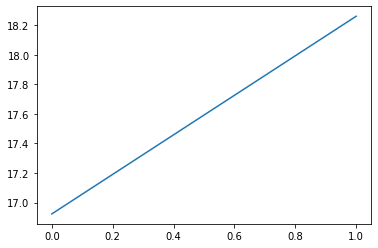

In [163]:
plt.plot(pre.history['val_loss'])

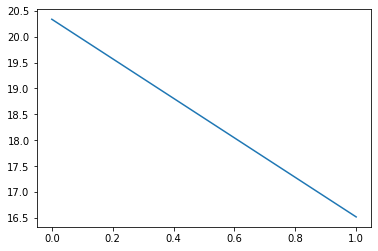

In [164]:
plt.plot(pre.history['loss'])

In [19]:
YOLO.save('./results/models/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./results/models/assets


## Evaluation

In [152]:
ml_metrics.mapk(actual=preds0[0], predicted=mb_train.__getitem__(0)[1][0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [24]:
len(X_val)

2510

In [28]:
X_val

['VOCdevkit/VOC2007/JPEGImages/000005.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000007.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000009.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000016.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000019.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000020.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000021.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000024.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000030.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000039.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000041.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000046.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000050.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000051.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000052.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000060.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000063.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000065.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000072.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000081.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000093.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000095.jpg',
 'VOCdevkit/VOC2007/JPEGImages/0

In [30]:
len(mb_test)

628

In [53]:
X_val

['VOCdevkit/VOC2007/JPEGImages/000005.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000007.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000009.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000016.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000019.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000020.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000021.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000024.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000030.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000039.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000041.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000046.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000050.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000051.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000052.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000060.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000063.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000065.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000072.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000081.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000093.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000095.jpg',
 'VOCdevkit/VOC2007/JPEGImages/0

In [102]:
img_cnt = 0
images = mb_test.images

for i in range(len(mb_test)):
    # Pull out a batch
    x_data, labels = mb_test.__getitem__(i)
    
    # Make a pred (4, 7, 7, 30)
    preds = YOLO.predict(x_data)
    
    for pred in preds.shape[0]:
        inter_preds = preds[pred]
        
        p_class = 
    

SyntaxError: invalid syntax (<ipython-input-102-96ca857fcd23>, line 11)

In [103]:
t0 = mb_test.__getitem__(0)[0]
t0.shape

[263 211 324 339   8]
8
VOCdevkit/VOC2007/JPEGImages/000005.jpg
[165 264 253 372   8]
8
VOCdevkit/VOC2007/JPEGImages/000005.jpg
[241 194 295 299   8]
8
VOCdevkit/VOC2007/JPEGImages/000005.jpg
[141  50 500 330   6]
6
VOCdevkit/VOC2007/JPEGImages/000007.jpg
[ 69 172 270 330  12]
12
VOCdevkit/VOC2007/JPEGImages/000009.jpg
[150 141 229 284  14]
14
VOCdevkit/VOC2007/JPEGImages/000009.jpg
[285 201 327 331  14]
14
VOCdevkit/VOC2007/JPEGImages/000009.jpg
[258 198 297 329  14]
14
VOCdevkit/VOC2007/JPEGImages/000009.jpg
[ 92  72 305 473   1]
1
VOCdevkit/VOC2007/JPEGImages/000016.jpg


(4, 448, 448, 3)

In [40]:
p0 = YOLO.predict(t0)

In [43]:
p0.shape[0]

4

In [45]:
p0[0][:,:,0]

array([[ 1.89625230e-02,  2.63512949e-03,  2.79147308e-02,
         6.34716358e-04,  1.61160100e-02,  1.34831143e-03,
         2.26064976e-02],
       [-1.58299704e-03,  2.18967069e-02,  4.07135766e-03,
         1.71062425e-02,  2.46661273e-03,  2.44011693e-02,
         2.72214646e-03],
       [ 1.38950245e-02,  4.32684133e-03,  5.05873263e-02,
         1.40623674e-02,  1.27542680e-02,  8.77713785e-03,
         2.78445687e-02],
       [ 3.38940695e-02,  1.95468646e-02,  5.21097146e-03,
         1.01149544e-06,  2.16550156e-02,  1.23196747e-02,
         1.26613239e-02],
       [ 5.38429944e-03,  1.38894282e-02,  1.21137844e-02,
         2.03630645e-02,  4.72763833e-03,  2.16064393e-04,
         7.29208626e-03],
       [ 1.30256684e-02,  1.13692217e-01,  1.93113282e-01,
         1.37457192e-01,  1.18153289e-01,  1.16459325e-01,
         1.34130225e-01],
       [ 3.40239555e-01,  2.73188025e-01,  4.38735068e-01,
         1.38466030e-01,  3.06175351e-01,  1.19565390e-01,
         2.2894415

In [85]:
x0, y0 = mb_test.__getitem__(0)

6
VOCdevkit/VOC2007/JPEGImages/000005.jpg
6
VOCdevkit/VOC2007/JPEGImages/000007.jpg
6
VOCdevkit/VOC2007/JPEGImages/000009.jpg
6
VOCdevkit/VOC2007/JPEGImages/000016.jpg


In [83]:
y0[3][..., 6]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [54]:
for i in range(20):
    print(f'{i}: {np.mean(p0[0][:,:,i])}')

0: 0.06396258622407913
1: 0.07879245281219482
2: 0.06688007712364197
3: 0.07236505299806595
4: 0.08292512595653534
5: 0.07190170139074326
6: 0.09523765742778778
7: 0.07165464758872986
8: 0.08150807023048401
9: 0.08175243437290192
10: 0.05560712888836861
11: 0.06548415869474411
12: 0.05954225733876228
13: 0.06330612301826477
14: 0.0845830887556076
15: 0.07290691137313843
16: 0.09006017446517944
17: 0.08103199303150177
18: 0.05996488034725189
19: 0.0654858648777008


In [56]:
classes_num

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [52]:
predict_class = p0[0][..., :20]
predict_class = np.reshape(predict_class, [7, 7, 1, 20])

In [111]:
# This grabs the 7x7 grids, one for each class...
# preds0 is (4, 7, 7, 30) --- batch_size of 4 
predict_class = preds0[0][..., :20]

# What is predict trust? IOU?
predict_trust = preds0[0][..., 20:22]

# prediction of box
predict_box = preds0[0][..., 22:]

In [112]:
predict_class = np.reshape(predict_class, [7, 7, 1, 20])
predict_trust = np.reshape(predict_trust, [7, 7, 2, 1])
predict_box = np.reshape(predict_box, [7, 7, 2, 4])

In [113]:
predict_scores = predict_class * predict_trust

In [114]:
predict_scores.shape

(7, 7, 2, 20)

In [115]:
box_classes = np.argmax(predict_scores, axis=-1)
box_classes

array([[[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]])

In [116]:
box_class_scores = np.max(predict_scores, axis=-1)
box_class_scores

array([[[ 0., -0.],
        [ 0.,  0.],
        [ 0., -0.],
        [ 0.,  0.],
        [-0.,  0.],
        [-0., -0.],
        [-0.,  0.]],

       [[-0., -0.],
        [ 0., -0.],
        [ 0.,  0.],
        [ 0., -0.],
        [-0., -0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [-0.,  0.],
        [ 0., -0.],
        [ 0.,  0.],
        [ 0., -0.],
        [-0., -0.],
        [-0., -0.]],

       [[ 0., -0.],
        [ 0.,  0.],
        [ 0., -0.],
        [ 0., -0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[-0., -0.],
        [ 0.,  0.],
        [-0.,  0.],
        [ 0.,  0.],
        [-0.,  0.],
        [ 0., -0.],
        [ 0.,  0.]],

       [[-0., -0.],
        [ 0., -0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., -0.],
        [-0.,  0.],
        [ 0., -0.]],

       [[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0.,  0.],
        [ 0., -0.],
        [ 0., -0.],
        [-0.,  0.]]], dtype=

In [97]:
best_box_class_scores = np.max(box_class_scores, axis=-1, keepdims=True)
best_box_class_scores

array([[[ 0.02276174],
        [ 0.00382082],
        [ 0.00334764],
        [ 0.0207351 ],
        [ 0.00608013],
        [ 0.00411715],
        [ 0.01118521]],

       [[ 0.05816355],
        [ 0.05788478],
        [ 0.02020029],
        [ 0.0305394 ],
        [ 0.01716673],
        [ 0.03258452],
        [ 0.02885432]],

       [[ 0.01338562],
        [ 0.08977873],
        [ 0.03496991],
        [ 0.31577104],
        [ 0.24809001],
        [ 0.03004746],
        [ 0.03437006]],

       [[ 0.0865645 ],
        [ 0.02611009],
        [ 0.01635412],
        [ 0.174822  ],
        [ 0.12079045],
        [ 0.02721281],
        [ 0.0644565 ]],

       [[ 0.00351149],
        [ 0.04641536],
        [ 0.01486403],
        [ 0.02007458],
        [ 0.0263782 ],
        [ 0.0044777 ],
        [ 0.01202748]],

       [[ 0.00096743],
        [ 0.05426973],
        [ 0.0199741 ],
        [ 0.01325764],
        [ 0.01312136],
        [ 0.0063681 ],
        [ 0.00188016]],

       [[-0.00258571],

In [98]:
box_mask = box_class_scores >= best_box_class_scores
box_mask

array([[[ True, False],
        [False,  True],
        [False,  True],
        [False,  True],
        [False,  True],
        [ True, False],
        [False,  True]],

       [[False,  True],
        [False,  True],
        [False,  True],
        [False,  True],
        [False,  True],
        [False,  True],
        [False,  True]],

       [[ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [False,  True]],

       [[False,  True],
        [False,  True],
        [ True, False],
        [ True, False],
        [False,  True],
        [False,  True],
        [ True, False]],

       [[ True, False],
        [False,  True],
        [False,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [False,  True]],

       [[ True, False],
        [False,  True],
        [False,  True],
        [ True, False],
        [ True, False],
        [False,  True],
      

In [99]:
filter_mask = box_class_scores >= 0.6
filter_mask *= box_mask
filter_mask

array([[[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
      

In [100]:
filter_mask = np.expand_dims(filter_mask, axis=-1)

In [117]:
predict_scores *= filter_mask  # 7 * 7 * 2 * 20
predict_box *= filter_mask  # 7 * 7 * 2 * 4

In [103]:
box_classes = np.expand_dims(box_classes, axis=-1)
box_classes *= filter_mask  # 7 * 7 * 2 * 1

In [105]:
def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = np.shape(feats)[0:2]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = np.arange(0, stop=conv_dims[0])
    conv_width_index = np.arange(0, stop=conv_dims[1])
    conv_height_index = np.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    conv_width_index = np.tile(np.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = np.reshape(np.transpose(conv_width_index), [conv_dims[0] * conv_dims[1]])
    conv_index = np.transpose(np.stack([conv_height_index, conv_width_index]))
    conv_index = np.reshape(conv_index, [conv_dims[0], conv_dims[1], 1, 2])

    conv_dims = np.reshape(conv_dims, [1, 1, 1, 2])

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh

In [106]:
box_xy, box_wh = yolo_head(pred_box)  # 7 * 7 * 2 * 2
box_xy_min, box_xy_max = xywh2minmax(box_xy, box_wh)

In [118]:
predict_trust *= filter_mask  # 7 * 7 * 2 * 1
nms_mask = np.zeros_like(filter_mask)  # 7 * 7 * 2 * 1
predict_trust_max = np.max(predict_trust)  

In [119]:
predict_trust_max

0.0

In [121]:
max_i = max_j = max_k = 0
while predict_trust_max > 0:
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if predict_trust[i, j, k, 0] == predict_trust_max:
                    nms_mask[i, j, k, 0] = 1
                    filter_mask[i, j, k, 0] = 0
                    max_i = i
                    max_j = j
                    max_k = k
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if filter_mask[i, j, k, 0] == 1:
                    iou_score = iou(box_xy_min[max_i, max_j, max_k, :],
                                    box_xy_max[max_i, max_j, max_k, :],
                                    box_xy_min[i, j, k, :],
                                    box_xy_max[i, j, k, :])
                    if iou_score > 0.2:
                        filter_mask[i, j, k, 0] = 0
    predict_trust *= filter_mask  # 7 * 7 * 2 * 1
    predict_trust_max = np.max(predict_trust)  # 找到置信度最高的框

box_xy_min *= nms_mask
box_xy_max *= nms_mask

In [124]:
X_val

['VOCdevkit/VOC2007/JPEGImages/000005.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000007.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000009.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000016.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000019.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000020.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000021.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000024.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000030.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000039.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000041.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000046.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000050.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000051.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000052.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000060.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000063.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000065.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000072.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000081.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000093.jpg',
 'VOCdevkit/VOC2007/JPEGImages/000095.jpg',
 'VOCdevkit/VOC2007/JPEGImages/0

In [ ]:
im = Image.open(image_path)
im = im.convert('RGB')

In [142]:
image = Image.open(X_val[0])
image = image.convert('RGB')
image = image.resize(size=(448, 448))
image = np.array(image)
origin_shape = image.shape[0:2]
detect_shape = filter_mask.shape

In [143]:
for i in range(detect_shape[0]):
        for j in range(detect_shape[1]):
            for k in range(detect_shape[2]):
                if nms_mask[i, j, k, 0]:
                    cv.rectangle(image, (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                                 (int(box_xy_max[i, j, k, 0]), int(box_xy_max[i, j, k, 1])),
                                 (0, 0, 255))
                    cv.putText(image, classes_name[box_classes[i, j, k, 0]],
                               (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                               1, 1, (0, 0, 255))

In [144]:
image2 = Image.open(X_val[0])

In [145]:
image.shape

(448, 448, 3)

In [ ]:
cv.

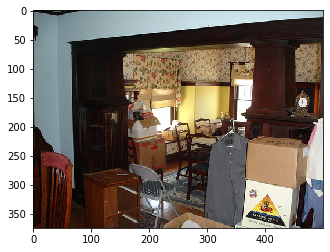

In [126]:
plt.imshow(Image.open(X_val[0]))

In [50]:
mb_train.aaa__getitem__(0)[0].shape

(4, 448, 448, 3)

In [56]:
mb_train.__getitem__(0)[1].shape

(4, 7, 7, 30)

In [54]:
preds0 = YOLO.predict(mb_train.__getitem__(0)[0])

In [70]:
preds0[0].shape

(7, 7, 30)

In [ ]:
prediction[..., :20]

In [71]:
preds0[0][:,:,0]

array([[ 0.44054234, -0.01231525,  0.07136334, -0.01713787, -0.01272885,
         0.45316258,  0.09964839],
       [-0.00450444,  0.40534678,  0.19085196,  0.17767449,  0.4897188 ,
         0.47269312,  0.08011612],
       [-0.02819723,  0.60515493,  0.44804487,  0.2703207 ,  0.5814532 ,
         0.379561  ,  0.01816316],
       [ 0.01667336,  0.02946681,  0.27765784,  0.21270342,  0.3549065 ,
        -0.13073896,  0.09846465],
       [ 0.03617146,  0.07181221,  0.1227854 , -0.05058271, -0.00296401,
         0.11828864, -0.0212226 ],
       [ 0.09034034, -0.1207445 , -0.01940449, -0.05551582,  0.00337076,
         0.01796911, -0.01638957],
       [ 0.19171527,  0.02133074,  0.03234426, -0.05153529, -0.00879285,
         0.01651776,  0.22894415]], dtype=float32)

In [82]:
preds0[0][..., :20]

array([[[ 4.40542340e-01, -1.01931887e-02, -2.38220440e-03,
         -2.38218368e-03, -7.29888007e-02,  1.09377652e-02,
          1.77668929e-01,  2.83611715e-02, -4.56438400e-03,
         -5.31605165e-03, -1.08932769e-02, -6.56977762e-03,
          1.10218478e-02, -1.25178508e-02,  2.27553427e-01,
          7.04943463e-02,  1.08079091e-01, -1.16213625e-02,
         -1.22491764e-02, -1.13160936e-02],
        [-1.23152472e-02,  7.30731431e-03,  1.28354859e-02,
          4.72874194e-02,  4.72763479e-02, -1.17460296e-01,
          4.56415474e-01,  1.26016781e-01, -1.65018775e-02,
          2.12603249e-02,  1.36054046e-02,  6.64533582e-03,
          2.50277761e-02,  8.21740776e-02,  9.19270515e-02,
         -2.55304202e-02,  2.16916740e-01,  7.33625004e-03,
          1.47297392e-02,  3.35735679e-02],
        [ 7.13633373e-02, -3.40428483e-03,  2.18154639e-01,
         -7.47175291e-02, -1.49655819e-01,  9.22309533e-02,
         -9.77566838e-03,  1.52499275e-02, -8.04444775e-02,
         -3.

In [78]:
for i in range(30):
    print(mb_train.__getitem__(0)[1][0][:,:,i])

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 

In [151]:
mb_train.__getitem__(0)[1][0].shape

(7, 7, 30)